In [1]:
import pandas as pd 
import numpy as np 
from scipy.stats import norm, expon, gamma, uniform, randint
import datetime
import holidays 
import matplotlib.pyplot as plt
import os
from pathlib import Path
import random
from faker import Faker
from unidecode import unidecode_expect_ascii
from itertools import repeat

In [2]:
#constants
shop_open_date = datetime.datetime(2021,6,1) #Dzień Dziecka bo tak 
today = datetime.datetime(2023,6,25)
staff_number = 6
tournament_number = 20
customers_number = 1500

# Faza 1 - przygotowanie

## Wczytanie csv

In [3]:
def file_path(file_name: str):
    dir_path = [ i for i in Path.cwd().parents if i.name == 'geeks-and-dragons-db'][0]
    path = os.path.join(dir_path, 'config', 'prompts', file_name)
    if os.path.exists(path):
        return path
    else:
        raise FileNotFoundError('No such file')

In [4]:
prompt_games = pd.read_csv(file_path('gry.csv'))
prompt_first_names_males = pd.read_csv(file_path('imiona_m.csv'))
prompt_last_names_males = pd.read_csv(file_path('nazwiska_m.csv'))
prompt_first_names_females = pd.read_csv(file_path('imiona_k.csv'))
prompt_last_names_females = pd.read_csv(file_path('nazwiska_k.csv'))
prompt_cities = pd.read_csv(file_path('miasta.csv'))
prompt_emails = pd.read_csv(file_path('Domeny.csv'))
prompt_tournaments = pd.read_csv(file_path('turnieje.csv'), delimiter=';')

## Tabela prompt_dates

In [5]:
weekday_dict = {'0':'Poniedziałek', '1':'Wtorek', '2':'Środa', '3':'Czwartek', '4':'Piątek', '5':'Sobota'}

def gen_dates(start_date, end_date):
    dates = []
    holidays_pl = holidays.Poland()
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() != 6 and current_date not in holidays_pl:
            dates.append((current_date.date().strftime("%d-%m-%Y"), weekday_dict[str(current_date.weekday())]))
        current_date += datetime.timedelta(days=1)
    return dates

In [6]:
generated_dates = gen_dates(shop_open_date, today)

In [7]:
prompt_dates = pd.DataFrame(generated_dates, columns=['Data', 'Dzień tygodnia'])
prompt_dates['Data'] = pd.to_datetime(prompt_dates['Data'], format='%d-%m-%Y')
prompt_dates['Data']

0     2021-06-01
1     2021-06-02
2     2021-06-04
3     2021-06-05
4     2021-06-07
         ...    
624   2023-06-20
625   2023-06-21
626   2023-06-22
627   2023-06-23
628   2023-06-24
Name: Data, Length: 629, dtype: datetime64[ns]

## Ruch - dni

In [8]:
A = 6
B = 0.01 
dodatek_dzienny = {'Poniedziałek':'2', 'Wtorek':'1', 'Środa':'0', 'Czwartek':'4', 'Piątek':'5', 'Sobota':'5'}

volume_base = []
for i in range(len(prompt_dates['Dzień tygodnia'])):
    dd = int(dodatek_dzienny[prompt_dates['Dzień tygodnia'][i]])
    volume_base.append(round(A+B*i+dd))

In [9]:
prompt_dates['volume_base'] = volume_base

In [10]:
volume_sales = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_sales.append(max(0,v_base+szum))

prompt_dates['volume_sales'] = volume_sales

In [11]:
volume_rental = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_rental.append(max(0,round(0.4*v_base+szum)))

prompt_dates['volume_rental'] = volume_rental

In [12]:
prompt_dates.head()

,Data,Dzień tygodnia,volume_base,volume_sales,volume_rental
0,2021-06-01,Wtorek,7,6,3
1,2021-06-02,Środa,6,7,3
2,2021-06-04,Piątek,11,11,3
3,2021-06-05,Sobota,11,11,2
4,2021-06-07,Poniedziałek,8,5,6


## Tabela procentowa z godzinami

In [13]:
hours = []
for i in range(8,20):
    if i < 18:
        hours.append((i, round(expon.rvs(i/2))))
    else:
        hours.append((i, round(expon.cdf(i/3))))          

In [14]:
hours_prompt = pd.DataFrame(hours, columns=['Godzina', 'Ilość klientów'])

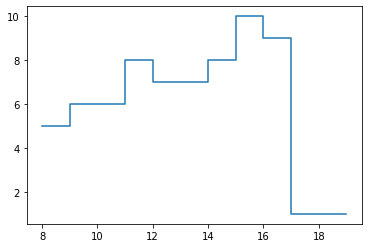

In [15]:
plt.step(range(8,20),hours_prompt['Ilość klientów'])

In [16]:
hours_prompt['Natężenie'] = [hours_prompt['Ilość klientów'][i]/sum(hours_prompt['Ilość klientów']) for i in range(len(hours_prompt['Godzina']))]

In [17]:
sum(hours_prompt['Natężenie'])

1.0

## Gry

In [18]:
prompt_games[1:] = prompt_games[1:].sample(frac = 1)

In [19]:
prompt_games.head()

,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Wypożyczenie,Liczba uczestników
0,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,NaN
1,Tajniacy,karciana,towarzyska,"Tajniacy próbują odgadnąć, które słowa ich sze...",TAK,49.90,8.0,8.0
2,Tiletum,planszowa,strategiczna,Czy zostaniesz najważniejszym kupcem renesanso...,NIE,148.00,NaN,NaN
3,Ego,inna,towarzyska,"Ego to kultowa gra towarzyska, która z pewnośc...",NIE,59.90,NaN,NaN
4,Jenga,inna,zręcznościowa,Cel gry jest prosty – musisz zostać ostatnim g...,TAK,59.94,4.0,2.0


In [20]:
wagi = expon.pdf(x=np.linspace(0,2,len(prompt_games['Nazwa'])),loc=-1/9)
prompt_games['wagi'] = [wagi[i]/np.sum(wagi) for i in range(len(wagi))]

In [21]:
prompt_games.head()

,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Wypożyczenie,Liczba uczestników,wagi
0,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,NaN,0.045967
1,Tajniacy,karciana,towarzyska,"Tajniacy próbują odgadnąć, które słowa ich sze...",TAK,49.90,8.0,8.0,0.044128
2,Tiletum,planszowa,strategiczna,Czy zostaniesz najważniejszym kupcem renesanso...,NIE,148.00,NaN,NaN,0.042363
3,Ego,inna,towarzyska,"Ego to kultowa gra towarzyska, która z pewnośc...",NIE,59.90,NaN,NaN,0.040669
4,Jenga,inna,zręcznościowa,Cel gry jest prosty – musisz zostać ostatnim g...,TAK,59.94,4.0,2.0,0.039043


_______________

# Faza 2 - tabele pomocnicze

## Pracownicy

In [22]:
id_generator = lambda n: [*range(1, n+1)]


gender_generator = lambda n: random.choices(['M', 'F'], weights=[0.5, 0.5], k=n) 


def phone_generator(n=6):
    WST = [45, 50, 51, 53, 57, 60, 66, 69, 72, 73, 78, 79, 88]
    digit = [i for i in range(10)]
    phone_numbers = []
    while n > 0:
        phone = ''.join(map(str, [random.choice(WST), *random.choices(digit, k=7)]))
        if phone not in phone_numbers:
            phone_numbers.append(phone)
            n -= 1
        else:
            pass
    return phone_numbers


def first_name_generator(df):
    gender_list = df['gender']
    names = []
    for gender in gender_list:
        if gender == 'M':
            names.append(*random.choices(prompt_first_names_males['imię'], weights=prompt_first_names_males['prob']))
        elif gender == 'F':
            names.append(*random.choices(prompt_first_names_females['imię'], weights=prompt_first_names_females['prob']))
    return names


def last_name_generator(df):
    gender_list = df['gender']
    last_names = []
    for gender in gender_list:
        if gender == 'M':
            last_names.append(*random.choices(prompt_last_names_males['nazwisko'], weights=prompt_last_names_males['prob']))
        elif gender == 'F':
            last_names.append(*random.choices(prompt_last_names_females['nazwisko'], weights=prompt_last_names_females['prob']))
    return last_names


def email_generator(df):
    name = df['first_name'].str.cat(df['last_name'], sep='.').apply(lambda x: unidecode_expect_ascii(x))
    while name.is_unique == False:
        name = name.apply(lambda x: x + str(random.choice(range(10))))
    df['email'] = name.apply(lambda x: '@'.join([x, random.choice(prompt_emails['Domena'])]))


def to_date_generator(n):
    dates = [np.nan for i in range(n)]
    dates[n-2] = Faker().date_between(shop_open_date + datetime.timedelta(days=90), today - datetime.timedelta(days=90))
    return dates


def from_date_generator(df):
    n = df.shape[0]
    end_date = df['to_date'].loc[df['to_date'].isnull() == False].values[0]
    dates = [shop_open_date for i in range(n)]
    dates[n-1] = end_date + datetime.timedelta(days=30)
    return dates


def staff_update_generator(df):
    n = df.shape[0]
    df_date = df[['to_date', 'from_date']]
    df['updated_at'] = df_date.max(axis=1, skipna=True, numeric_only = False).apply(lambda x: x + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60))))
    

def salary_generator(df):
    n = df.shape[0]
    df['current_salary'] = [round(3490 + expon.rvs(scale=100, loc=80), 2) for i in range(n)]
    df.loc[df['to_date'].isnull() == False, 'current_salary'] = np.nan


def is_manager(df):
    n = df.shape[0]
    df['is_manager'] = [False for i in range(n)]
    df.loc[df['current_salary'] == df['current_salary'].max(), 'is_manager'] = True

In [23]:
def staff_df_generator(n):
    staff = pd.DataFrame({
        'gender': [*gender_generator(n)],
        'phone': [*phone_generator(n)],
        'to_date': [*to_date_generator(n)]
    })
    staff['city'] = np.full((1, staff.shape[0]), 'Wrocław')[0]
    staff['from_date'] = from_date_generator(staff)
    staff['first_name'] = first_name_generator(staff)
    staff['last_name'] = last_name_generator(staff)
    email_generator(staff)
    salary_generator(staff)
    is_manager(staff)
    staff_update_generator(staff)
    staff.sort_values(by=['updated_at'], inplace=True)
    staff['staff_id'] = id_generator(n)
    staff = staff.reindex(labels=['staff_id','first_name', 'last_name', 'phone', 'email', 'city', 'current_salary', 'is_manager', 'gender', 'from_date', 'to_date', 'updated_at'], axis=1)
    return staff

In [24]:
staff = staff_df_generator(staff_number)
staff

,staff_id,first_name,last_name,phone,email,city,current_salary,is_manager,gender,from_date,to_date,updated_at
2,1,BOGDAN,MISZCZUK,534681266,BOGDAN.MISZCZUK@neostrada.pl,Wrocław,3606.97,False,M,2021-06-01,NaN,2021-06-01 09:01:48
3,2,JÓZEF,SUPIŃSKI,780984615,JOZEF.SUPINSKI@interia.pl,Wrocław,3646.03,False,M,2021-06-01,NaN,2021-06-01 09:26:53
0,3,DMYTRO,GWÓŹDŹ,601881392,DMYTRO.GWOZDZ@neostrada.pl,Wrocław,3601.27,False,M,2021-06-01,NaN,2021-06-01 11:51:58
1,4,MARTYNA,BIAŁEK,535531788,MARTYNA.BIALEK@gazeta.pl,Wrocław,3625.77,False,F,2021-06-01,NaN,2021-06-01 17:22:24
4,5,BOŻENNA,PABIAN,697959513,BOZENNA.PABIAN@home.pl,Wrocław,NaN,False,F,2021-06-01,2022-09-16,2022-09-16 12:32:28
5,6,PAWEŁ,SKAŁECKI,514062781,PAWEL.SKALECKI@go2.pl,Wrocław,3789.33,True,M,2022-10-16,NaN,2022-10-16 13:17:00


## Godziny pracy

In [25]:
def weekday_hour_worker_generator():    
    hours = range(8,20)
    weekdays = ['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota']

    w = []
    h = []
    for i in hours:
        for j in weekdays:
            w.append(j)
            h.append(i)
    wk = []
    for i in h:
        if i < 14:
            wk.append((1,2))
        else:
            wk.append((3,4,6))
            
    weekday_hour_worker = pd.DataFrame({
        'weekdays': w, 
        'hour': h, 
        'staff': wk
    })
    return weekday_hour_worker

In [26]:
weekday_hour_worker = weekday_hour_worker_generator()
weekday_hour_worker.head()

,weekdays,hour,staff
0,Poniedziałek,8,"(1, 2)"
1,Wtorek,8,"(1, 2)"
2,Środa,8,"(1, 2)"
3,Czwartek,8,"(1, 2)"
4,Piątek,8,"(1, 2)"


## Związki

In [27]:
#losowanie wektora z rozkładu normalnego z warunkiem na wartość minimalną
def norm_with_condition_generator(n, loc, scale, condition):
    dates = norm.rvs(scale=scale, loc=loc, size=n)
    mask = dates > condition
    while mask.all()== False:
        dates = norm.rvs(scale=scale, loc=loc, size=n)
        mask = dates > condition
    return dates.round().astype(int)

In [28]:
N = int(np.ceil(staff_number*1.5))


def realtionships_df_generator(staff_df, n=N):
    staff_id = []
    staff_gender = []
    update = []
    staff_df = staff_df.loc[staff_df['current_salary'].isnull() == False]
    for i in range(n):
        employee = random.choices(staff_df.staff_id.values, weights=staff_df.current_salary.values)
        staff_id.append(*employee)
        staff_gender.append(*staff_df['gender'].loc[staff_df.staff_id == employee[0]].values)
        update.append(Faker().date_between_dates(pd.to_datetime(staff_df.from_date.loc[staff_df.staff_id == employee[0]].values[0]), today) + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60))))
    df = pd.DataFrame({
        'staff_id': staff_id,
        'staff_gender': staff_gender,
        'dates_number': norm_with_condition_generator(n, 5, 2, 0),
        'updated_at': update
    })
    df.sort_values(by=['updated_at'], inplace=True)
    df['relationship_id'] = id_generator(df.shape[0])
    df['partner_id'] = id_generator(df.shape[0])
    df = df.reindex(labels=['relationship_id', 'staff_id','staff_gender', 'partner_id', 'dates_number', 'updated_at'], axis=1)
    return df

In [29]:
relationships = realtionships_df_generator(staff)
relationships

,relationship_id,staff_id,staff_gender,partner_id,dates_number,updated_at
0,1,3,M,1,6,2021-06-20 13:26:19
7,2,4,F,2,5,2021-10-28 14:07:51
4,3,4,F,3,5,2022-06-03 19:36:47
6,4,3,M,4,5,2022-07-06 17:49:32
3,5,3,M,5,4,2022-07-27 16:01:48
8,6,2,M,6,7,2022-08-07 10:47:07
1,7,6,M,7,6,2022-10-20 13:07:58
2,8,6,M,8,3,2023-02-22 12:52:44
5,9,6,M,9,6,2023-03-10 15:08:02


## Partnerzy

In [30]:
def partners_df_generator(relationships_df):
    partner = relationships_df.partner_id
    staff_gender = relationships_df.staff_gender.values
    gender = []
    for el in staff_gender:
        if el == 'M':
            gender.append(random.choices(['M', 'F'], weights=[0.1, 0.9])[0])
        elif el == 'F':
            gender.append(random.choices(['M', 'F'], weights=[0.9, 0.1])[0])

    partners = pd.DataFrame({
        'partner_id': partner,
        'gender': gender,
        'updated_at': relationships_df.updated_at
    })
    partners['name'] = first_name_generator(partners)
    partners.sort_values(by=['updated_at'], inplace=True)
    partners = partners.reindex(labels=['partner_id', 'name', 'gender', 'updated_at'], axis=1)
    return partners

In [31]:
partners = partners_df_generator(relationships)
partners

,partner_id,name,gender,updated_at
0,1,MARIANNA,F,2021-06-20 13:26:19
7,2,PAWEŁ,M,2021-10-28 14:07:51
4,3,ŁUKASZ,M,2022-06-03 19:36:47
6,4,NATALIA,F,2022-07-06 17:49:32
3,5,DAMIAN,M,2022-07-27 16:01:48
8,6,ZOFIA,F,2022-08-07 10:47:07
1,7,ARDIAN,M,2022-10-20 13:07:58
2,8,NIKODEM,M,2023-02-22 12:52:44
5,9,ANNA,F,2023-03-10 15:08:02


## Klienci - część A

In [32]:
customers = pd.DataFrame({'customer_id': id_generator(customers_number)})

## Koszty utrzymania

In [33]:
def expenses_dates_generator(day=5):
    base = pd.DataFrame(prompt_dates.loc[(prompt_dates['Data'].dt.day == day) | (prompt_dates['Data'].dt.day == day+1), 'Data'])
    base['flag'] = base['Data'].dt.to_period('M') 
    base.drop_duplicates(['flag'], keep='first', inplace=True)
    base = base.reset_index()
    return base['Data']

In [34]:
def rent_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'CZYNSZ ' + str(x).upper())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': np.full((1, date_df.shape[0]), 3250)[0],
        'type': np.full((1, date_df.shape[0]), 'CZYNSZ')[0]
    })
    return df


def energy_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'ENERGIA ELEKTRYCZNA ' + str(x).upper())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [max(round(norm.rvs(150,4),2),100) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'MEDIA')[0]
    })
    return df

def water_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'WODA ' + str(x).upper())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [max(round(norm.rvs(50,2),2),15) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'MEDIA')[0]
    })
    return df


def heat_generator():
    dates = []
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    for j in range(2021,2024):
        for i in range(4,11):
            day = datetime.datetime(j,i,5)
            dates.append(day.strftime("%Y-%m-%d"))
    for i in dates:
        date_df = date_df.drop(date_df[date_df == i].index)
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'OGRZEWANIE ' + str(x).upper())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [round(norm.rvs(100,4),2) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'MEDIA')[0]
    })
    return df


def salary_generator(staff_df):
    date_df = expenses_dates_generator(10)
    all_staff = pd.concat([staff_df[['first_name', 'last_name', 'current_salary']]]*date_df.shape[0], ignore_index=True)
    staff_name = staff_df['first_name'].str.cat(staff_df['last_name'], sep=' ')
    names = pd.concat([staff_name]*date_df.shape[0], ignore_index=True)
    dates = np.repeat(date_df, staff_name.shape[0])
    dates = dates.reset_index()['Data']
    title_first = dates.dt.month_name(locale='pl_PL').apply(lambda x: 'PENSJA ' + str(x).upper())
    title = title_first.str.cat(names, sep=' ')
    df = pd.DataFrame({
        'date': dates,
        'title': title,
        'amount': all_staff['current_salary'],
        'type': np.full((1, title.shape[0]), 'PENSJA')[0]
    })
    to_date = pd.to_datetime(staff_df['to_date'].loc[staff_df['to_date'].isnull() == False].values[0])
    df.loc[(df['amount'].isnull() == True) & (df['date'] < to_date), 'amount'] = round(3490 + expon.rvs(scale=100, loc=80), 2)
    df.dropna(inplace=True)
    return df


def maintenance_expenses_df_generator():
    df = pd.DataFrame({
        'date': [],
        'title': [],
        'amount': [],
        'type': [],
        'updated_at': []
    })
    df = pd.concat([df, rent_generator(), energy_generator(), water_generator(), heat_generator(), salary_generator(staff)])
    df['updated_at'] = df['date'].apply(lambda x: x + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60))))
    df.sort_values(by=['updated_at'], inplace=True)
    df['payment_id'] = id_generator(df.shape[0])
    df['invoice_id'] = id_generator(df.shape[0])
    df['spend_id'] = id_generator(df.shape[0])
    df = df.reindex(['spend_id', 'title', 'amount', 'type','date', 'payment_id', 'invoice_id', 'updated_at'], axis=1)
    return df

In [35]:
maintenance_expenses = maintenance_expenses_df_generator()
maintenance_expenses

,spend_id,title,amount,type,date,payment_id,invoice_id,updated_at
3,1,WODA CZERWIEC,46.89,MEDIA,2021-06-05,1,1,2021-06-05 13:21:59
3,2,CZYNSZ CZERWIEC,3250.00,CZYNSZ,2021-06-05,2,2,2021-06-05 19:05:37
3,3,ENERGIA ELEKTRYCZNA CZERWIEC,142.08,MEDIA,2021-06-05,3,3,2021-06-05 19:58:45
3,4,PENSJA CZERWIEC MARTYNA BIAŁEK,3625.77,PENSJA,2021-06-10,4,4,2021-06-10 08:36:08
0,5,PENSJA CZERWIEC BOGDAN MISZCZUK,3606.97,PENSJA,2021-06-10,5,5,2021-06-10 09:45:20
...,...,...,...,...,...,...,...,...
146,204,PENSJA CZERWIEC DMYTRO GWÓŹDŹ,3601.27,PENSJA,2023-06-10,204,204,2023-06-10 08:05:47
149,205,PENSJA CZERWIEC PAWEŁ SKAŁECKI,3789.33,PENSJA,2023-06-10,205,205,2023-06-10 10:59:04
144,206,PENSJA CZERWIEC BOGDAN MISZCZUK,3606.97,PENSJA,2023-06-10,206,206,2023-06-10 12:27:53
147,207,PENSJA CZERWIEC MARTYNA BIAŁEK,3625.77,PENSJA,2023-06-10,207,207,2023-06-10 12:47:46


## Typy wydatków

In [36]:
def expense_types_df_generator(expense_df):
    df = pd.DataFrame({
        'expenses_type': expense_df['type'],
        'updated_at': expense_df['updated_at']
    })
    df.drop_duplicates(subset=['expenses_type'], keep='last', inplace=True)
    df.sort_values(by=['updated_at'], inplace=True)
    df['expenses_type_id'] = id_generator(df.shape[0])
    df = df.reindex(['expenses_type_id', 'expenses_type', 'updated_at'], axis=1)
    return df

In [37]:
expense_types = expense_types_df_generator(maintenance_expenses)
expense_types

,expenses_type_id,expenses_type,updated_at
612,1,CZYNSZ,2023-06-05 09:29:04
612,2,MEDIA,2023-06-05 18:26:54
145,3,PENSJA,2023-06-10 13:21:24


## Tytuły wydatków

In [38]:
def expense_titles_df_generator(expense_df, expense_types_df):
    df = pd.DataFrame({
        'title': expense_df['title'],
        'expenses_type': expense_df['type'],
        'updated_at': expense_df['updated_at']
    })
    df.drop_duplicates(subset=['title'], keep='last', inplace=True)
    df = pd.merge(df, expense_types_df[['expenses_type_id', 'expenses_type']], how='left', on=['expenses_type'])
    df.sort_values(by=['updated_at'], inplace=True)
    df['title_id'] = id_generator(df.shape[0])
    df = df.reindex(['title_id', 'title', 'expenses_type_id', 'updated_at'], axis=1)
    return df

In [39]:
expense_titles = expense_titles_df_generator(maintenance_expenses, expense_types)
expense_titles.head()

,title_id,title,expenses_type_id,updated_at
0,1,PENSJA PAŹDZIERNIK BOŻENNA PABIAN,3,2021-10-11 08:57:57
1,2,PENSJA LISTOPAD BOŻENNA PABIAN,3,2021-11-10 15:54:17
2,3,PENSJA GRUDZIEŃ BOŻENNA PABIAN,3,2021-12-10 17:00:46
3,4,PENSJA STYCZEŃ BOŻENNA PABIAN,3,2022-01-10 18:08:56
4,5,OGRZEWANIE LUTY,2,2022-02-05 09:34:07


## Wydatki i tytuły jeszcze raz

In [40]:
maintenance_expenses2 = pd.merge(maintenance_expenses, expense_titles[['title_id', 'title']], how='left', on='title')
maintenance_expenses2.sort_values(by=['updated_at'], inplace=True)
maintenance_expenses2 = maintenance_expenses2.reindex(['spend_id', 'title_id', 'type', 'amount','payment_id', 'invoice_id', 'updated_at'], axis=1)

In [41]:
maintenance_expenses2.head()

,spend_id,title_id,type,amount,payment_id,invoice_id,updated_at
0,1,107,MEDIA,46.89,1,1,2021-06-05 13:21:59
1,2,106,CZYNSZ,3250.00,2,2,2021-06-05 19:05:37
2,3,108,MEDIA,142.08,3,3,2021-06-05 19:58:45
3,4,112,PENSJA,3625.77,4,4,2021-06-10 08:36:08
4,5,111,PENSJA,3606.97,5,5,2021-06-10 09:45:20


## Turnieje

In [42]:
def game_tournament_generator():
    games = prompt_games.loc[prompt_games['Turniej'] == 'TAK', ['Nazwa', 'rodzaj', 'kategoria']]
    tournament_games = pd.merge(games, prompt_tournaments, left_on=['rodzaj', 'kategoria'], right_on=['Rodzaj', 'Kategoria'], suffixes=['_gry', '_turnieju'])
    tournament_games = tournament_games[['Nazwa_gry', 'Nazwa_turnieju']]
    return tournament_games


def tournament_staff_generator():
    staff = weekday_hour_worker.loc[(weekday_hour_worker['weekdays'] == 'Piątek') & (weekday_hour_worker['hour'] >= 15)]['staff'].sample(1, replace=True)
    return random.choice(staff.values[0])


def count_matches(x):
    suma = 0
    while x >= 0:
        suma += 2**x
        x -= 1
    return suma


In [43]:
def tournaments_df_generator():
    dates = pd.DataFrame(prompt_dates.loc[prompt_dates['Dzień tygodnia'] == 'Piątek', 'Data'].iloc[::6]).reset_index()['Data']
    n = dates.shape[0]
    tournament = game_tournament_generator()
    tournament = tournament.sample(n, replace=False, ignore_index=True) #nie może być ten sam wiersz
    tree_levels_number = randint.rvs(2, 4, size=n)
    matches = map(lambda x: count_matches(x), tree_levels_number)
    df = pd.DataFrame({
        'name': tournament['Nazwa_turnieju'],
        'game': tournament['Nazwa_gry'],
        'start_time': dates + datetime.timedelta(hours=15),
        'matches': matches,
        'tree_levels': tree_levels_number,
        'fee': np.full((1, n), 50)[0],
        'sign_up_deadline': dates - datetime.timedelta(days=3) + datetime.timedelta(hours=20),
        'staff_id': [tournament_staff_generator() for i in range(n)],
        'expenses': map(lambda x: round(x, 2), gamma.rvs(a=1.5, loc=200, scale=20, size=n)),
        'updated_at': dates.apply(lambda x: x + datetime.timedelta(hours=15, minutes=random.randint(1,5), seconds=random.randint(1,59)))
    })
    df.sort_values(by=['updated_at'], inplace=True)
    df['tournament_id'] = id_generator(n)
    df = df.reindex(['tournament_id', 'name', 'game', 'start_time', 'matches', 'tree_levels', 'fee', 'sign_up_deadline', 'staff_id', 'expenses', 'updated_at'], axis=1)
    return df

In [44]:
tournaments = tournaments_df_generator()
tournaments.head()

,tournament_id,name,game,start_time,matches,tree_levels,fee,sign_up_deadline,staff_id,expenses,updated_at
0,1,Cytadela Strategii,7 Cudów Świata,2021-06-04 15:00:00,15,3,50,2021-06-01 20:00:00,6,296.49,2021-06-04 15:04:09
1,2,Cytadela Strategii,Terraformacja Marsa,2021-07-16 15:00:00,15,3,50,2021-07-13 20:00:00,4,321.93,2021-07-16 15:04:17
2,3,Wrocławski Konwent Planszówkowy,Catan: Osadnicy z Catanu,2021-08-27 15:00:00,7,2,50,2021-08-24 20:00:00,4,211.08,2021-08-27 15:05:20
3,4,Labirynt Logicznych Umysłów,Mastermind,2021-10-08 15:00:00,15,3,50,2021-10-05 20:00:00,6,255.13,2021-10-08 15:02:08
4,5,Krucjata Karcianych Mistrzów,UNO,2021-11-19 15:00:00,7,2,50,2021-11-16 20:00:00,4,222.45,2021-11-19 15:03:57


## Udziały

In [45]:
def sign_up_date_generator(deadline):
    date = prompt_dates['Data'].loc[(prompt_dates['Data'] < deadline) & (prompt_dates['Data'] > deadline - datetime.timedelta(days=14))].sample(1, ignore_index=True).values
    date = date[0] + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60)))
    return date

In [46]:
def participations_df_generator(tournament_df, customers_df):
    #liczba uczestników
    players = pd.merge(tournament_df[['game', 'tree_levels', 'tournament_id', 'fee', 'sign_up_deadline']], prompt_games[['Nazwa', 'Liczba uczestników']], left_on=['game'], right_on=['Nazwa'], how='left')
    players['Liczba uczestników'] = players['Liczba uczestników'].astype('int')
    players_number = players['Liczba uczestników'] * (2**players['tree_levels'])
    players['players'] = players_number

    #customer_id i miejsce
    participants = map(lambda x: customers_df['customer_id'].sample(x, replace=False, ignore_index=True).values, players_number)
    players['place'] = players['players'].apply(lambda x: [*range(1, x+1)])
    players['customer_id'] = list(participants)

    #ostateczny df
    df = players[['tournament_id', 'customer_id', 'fee', 'sign_up_deadline', 'place']]
    df = df.explode(['customer_id', 'place'], ignore_index=True)
    df['sign_up_date'] = df['sign_up_deadline'].apply(lambda x: sign_up_date_generator(x))
    df['updated_at'] = df['sign_up_date'].copy()
    df.sort_values(by=['updated_at'], inplace=True)
    df['particip_id'] = id_generator(df.shape[0])
    df = df.reindex(['particip_id', 'tournament_id', 'customer_id', 'place', 'sign_up_date', 'fee', 'updated_at'], axis=1)
    return df

In [47]:
participations = participations_df_generator(tournaments, customers)
participations.head()

,particip_id,tournament_id,customer_id,place,sign_up_date,fee,updated_at
6,1,1,526,7,2021-06-01 08:06:40,50,2021-06-01 08:06:40
37,2,1,1138,38,2021-06-01 08:19:00,50,2021-06-01 08:19:00
16,3,1,476,17,2021-06-01 08:29:31,50,2021-06-01 08:29:31
19,4,1,1487,20,2021-06-01 08:43:11,50,2021-06-01 08:43:11
9,5,1,1252,10,2021-06-01 08:45:06,50,2021-06-01 08:45:06


## Magazyn

In [48]:
def get_value_from_another_column(df, search_column, search_value, target_column):
    matching_rows = df.loc[df[search_column] == search_value]
    target_value = matching_rows[target_column].values[0]
    return target_value


def sell(): 
    N = sum(prompt_dates['volume_sales'])*expon.rvs(loc=1/4)
    while N < 2500 or N > 3700: 
        N = sum(prompt_dates['volume_sales'])*expon.rvs(loc=1/4)
    ilość = list(map(round,prompt_games['wagi']*N))
    M = [prompt_games['Nazwa'][i:i+5] for i in range(0, len(prompt_games['Nazwa']), 5)]
    daty = []
    datysklepowe = list(prompt_dates['Data'].dt.strftime('%Y-%m-%d'))
    ilość2 = [sum(ilość[i:i+5]) for i in range(0,51,5)]
    for i in range(len(M)):
        d = max(len(M) + round(norm.rvs(0,5)),1)
        day = datetime.datetime(random.choice(range(2021,2024)),random.choice(range(1,13)),d).strftime("%Y-%m-%d")
        while day not in datysklepowe:
            day = datetime.datetime(random.choice(range(2021, 2024)), random.choice(range(1, 13)), d).strftime("%Y-%m-%d")
        daty.append(day)
    index = [x for x, y in zip(range(1,len(M)+1), ilość2) for _ in range(y)]
    indexy = [x for x, y in zip(index, ilość2) for _ in range(y)]
    daty_dost = [x for x, y in zip(daty, ilość2) for _ in range(y)]
    game = [x for x, y in zip(prompt_games['Nazwa'], ilość) for _ in range(y)]
    upd = [datetime.datetime.strptime(i, '%Y-%m-%d').replace(hour=random.randint(8, 19), minute=random.randint(0, 59), second=random.randint(0, 59)) for i in daty_dost]
    ceny = [x for x, y in zip(prompt_games['Kupno'], ilość2) for _ in range(y)]
    df = pd.DataFrame({
        'game': game,
        'destination': ['S' for _ in range(len(indexy))],
        'price': ceny,
        'active': [True for i in range(len(upd))],
        'purchase_payment': [round(0.8*cena, 2) for cena in ceny],
        'delivery_date': upd,
        'updated_at': upd
    }) 
    return df


def rental():
    N = 70
    games_r = [random.choice(prompt_games['Nazwa']) for i in range(N)]
    daty = ['2021-06-01' for _ in range(N)]
    daty_upd = [datetime.datetime.strptime(i, '%Y-%m-%d').replace(hour=random.randint(8, 19), minute=random.randint(0, 59), second=random.randint(0, 59)) for i in daty]
    df = pd.DataFrame({
        'game': games_r,
        'destination': ['R' for _ in range(N)],
        'price': [round(0.1*get_value_from_another_column(prompt_games,'Nazwa',gra,'Kupno'),2) for gra in games_r],
        'active': [True for i in range(N)],
        'purchase_payment': [round(0.8*get_value_from_another_column(prompt_games,'Nazwa',gra,'Kupno'),2) for gra in games_r],
        'delivery_date': daty_upd,
        'updated_at': daty_upd
    }) 
    return df


def games_for_tournament(tournaments_df):
    games_amount = tournaments_df[['game', 'tree_levels']].groupby('game').max().apply(lambda x: 2**x)
    games = pd.merge(games_amount, prompt_games, left_on=['game'], right_on=['Nazwa'])[['tree_levels', 'Nazwa', 'Kupno']]
    n = games.shape[0]
    dates = ['2021-06-01' for _ in range(n)]
    updated = [datetime.datetime.strptime(i, '%Y-%m-%d').replace(hour=random.randint(8, 19), minute=random.randint(0, 59), second=random.randint(0, 59)) for i in dates]
    df = pd.DataFrame({
        'game': games['Nazwa'],
        'destination': ['T' for _ in range(n)],
        'price': [np.nan for i in range(n)],
        'active': [True for i in range(n)],
        'purchase_payment': games['Kupno'],
        'delivery_date': updated,
        'updated_at': updated
    })
    return df


def inventory_df_generator(tournaments_df):
    sell_df = sell()
    rental_df = rental()
    tournament_df = games_for_tournament(tournaments_df)
    df = pd.concat([sell_df, rental_df, tournament_df])
    df.sort_values(by=['updated_at'], inplace=True)
    df['inventory_id'] = id_generator(df.shape[0])
    df = df.reindex(['inventory_id', 'game', 'destination', 'price', 'active', 'purchase_payment', 'delivery_date', 'updated_at'], axis=1)
    return df

In [49]:
inventory = inventory_df_generator(tournaments)
inventory.head()

,inventory_id,game,destination,price,active,purchase_payment,delivery_date,updated_at
25,1,Koty,R,5.3,True,42.40,2021-06-01 08:09:40,2021-06-01 08:09:40
29,2,Super Farmer,R,3.4,True,27.20,2021-06-01 08:28:03,2021-06-01 08:28:03
48,3,Ekosystem,R,5.4,True,43.22,2021-06-01 08:32:27,2021-06-01 08:32:27
4,4,Monopoly Classic,T,NaN,True,115.90,2021-06-01 08:35:31,2021-06-01 08:35:31
1,5,Dobry rok,R,16.1,True,128.78,2021-06-01 08:49:15,2021-06-01 08:49:15


## Ceny gier

In [50]:
def game_prices_df_generator(inventory_df):
    df = inventory_df.drop_duplicates(subset=['price'], keep='last', ignore_index=True)[['price', 'updated_at']]
    df.rename(columns={'price': 'current_price'}, inplace=True)
    df = df.sort_values(['updated_at'])
    df['price_id'] = id_generator(df.shape[0])
    df = df.reindex(['price_id', 'current_price', 'updated_at'], axis=1)
    return df

In [51]:
game_prices = game_prices_df_generator(inventory)
game_prices.head()

,price_id,current_price,updated_at
0,1,5.30,2021-06-01 08:09:40
1,2,2.62,2021-06-01 09:05:12
2,3,2.60,2021-06-01 09:11:29
3,4,4.50,2021-06-01 09:53:21
4,5,6.09,2021-06-01 10:04:04


## Sprzedaże

In [52]:
def sales_df_generator(inventory_df):
    all_date = []
    price = []
    invoice = []
    staff = []
    inventory = []
    for j in range(prompt_dates['Data'].shape[0]):
        for i in range(prompt_dates['volume_sales'][j]):
            hour = random.choices(hours_prompt['Godzina'], weights=hours_prompt['Natężenie'], k=1)[0]
            date = prompt_dates['Data'][j] + datetime.timedelta(hours=int(hour), minutes=random.randint(0, 59), seconds=random.randint(0, 59))
            P = random.choices([1, 2, 3], weights=[0.7, 0.25, 0.05])[0]
            games = random.choices(prompt_games['Nazwa'], weights=prompt_games['wagi'], k=P)
            available_staff = weekday_hour_worker.loc[(weekday_hour_worker['weekdays'] == date.day_name(locale='pl_PL')) & (weekday_hour_worker['hour'] == date.hour)]['staff'].sample(1, replace=True)
            staff_id = random.choice(available_staff.values[0])
            for k in games:
                mask = (inventory_df['game'] == k) & (inventory_df['delivery_date'] < date) & (inventory_df['destination'] == 'S') & (inventory_df['active'] == True)
                if mask.any():
                    inventory_df.loc[mask.idxmax(), 'active'] = False
                    price.append(inventory_df['price'].loc[mask.idxmax()])
                    all_date.append(date)
                    invoice.append((i, j))
                    staff.append(staff_id)
                    inventory.append(inventory_df['inventory_id'].loc[mask.idxmax()])
                    
    df = pd.DataFrame({
        'inventory_id': inventory,
        'price': price,
        'invoice': invoice, 
        'staff_id': staff,
        'date': all_date,
        'updated_at': all_date
    })
    df.sort_values('updated_at', inplace=True)
    df['sale_id'] = id_generator(df.shape[0])
    df = df.reindex(['sale_id', 'inventory_id', 'staff_id', 'price', 'date', 'updated_at'], axis=1)
    return df


In [53]:
sales = sales_df_generator(inventory)

In [54]:
sales.head()

,sale_id,inventory_id,staff_id,price,date,updated_at
2,1,334,1,53.0,2021-08-12 11:49:10,2021-08-12 11:49:10
0,2,337,4,53.0,2021-08-12 14:14:38,2021-08-12 14:14:38
3,3,92,6,59.94,2021-08-12 16:01:51,2021-08-12 16:01:51
1,4,86,3,59.94,2021-08-12 17:22:23,2021-08-12 17:22:23
5,5,333,2,53.0,2021-08-13 08:06:28,2021-08-13 08:06:28


## Rentale

## Gry

In [55]:
def games_df_generator(inventory_df): 
    update = inventory_df[['game', 'delivery_date']].groupby(['game']).min()
    games = pd.merge(prompt_games, update, left_on=['Nazwa'], right_on=['game'])
    games = games[['Nazwa', 'opis', 'kategoria', 'rodzaj', 'Turniej', 'delivery_date']]
    games.rename(columns={
        'Nazwa': 'title',
        'opis': 'description',
        'kategoria': 'category',
        'rodzaj': 'type',
        'Turniej': 'competitivity',
        'delivery_date': 'updated_at'}, inplace=True)
    games['competitivity'] = games['competitivity'].apply(lambda x: True if x == 'TAK' else False)
    games.sort_values(['updated_at'], inplace=True)
    games['game_id'] = id_generator(games.shape[0])
    games = games.reindex(['game_id', 'title', 'description', 'category', 'type', 'competitivity', 'updated_at'], axis=1)
    return games

In [56]:
games = games_df_generator(inventory)
games.head()

,game_id,title,description,category,type,competitivity,updated_at
7,1,Koty,Podczas gry w Koty odwiedzicie 4 krainy ze snó...,towarzyska,karciana,False,2021-06-01 08:09:40
41,2,Super Farmer,Super Farmer to kultowa gra rodzinna o strateg...,familijna,inna,True,2021-06-01 08:28:03
46,3,Ekosystem,Gra pełna harmonii i równowagi. Jak w przyrodz...,familijna,karciana,False,2021-06-01 08:32:27
36,4,Monopoly Classic,Monopoly Standard to kultowa i znana na całym ...,familijna,planszowa,True,2021-06-01 08:35:31
35,5,Dobry rok,"Gra ""Dobry Rok"" sprawdzi się u dzieci w wieku ...",strategiczna,planszowa,False,2021-06-01 08:49:15


## Katrgorie gier i typy gier

In [57]:
def game_categories_df_generator(games_df):
    df = games_df[['category', 'updated_at']].drop_duplicates('category', keep='first')
    df.rename(columns={'category': 'game_category'}, inplace=True)
    df['category_id'] = id_generator(df.shape[0])
    df = df.reindex(['category_id', 'game_category', 'updated_at'], axis=1)
    return df


In [58]:
game_categories = game_categories_df_generator(games)
game_categories

,category_id,game_category,updated_at
7,1,towarzyska,2021-06-01 08:09:40
41,2,familijna,2021-06-01 08:28:03
35,3,strategiczna,2021-06-01 08:49:15
13,4,logiczna,2021-06-01 09:05:12
42,5,zręcznościowa,2021-06-01 09:53:21
38,6,stretegiczna,2021-06-01 12:47:59
29,7,kolekcjonerska,2021-06-01 15:50:19
47,8,narracyjna,2021-06-01 17:31:01
6,9,przygodowa,2023-03-13 08:06:48


--------

In [59]:
def game_types_df_generator(games_df):
    df = games_df[['type', 'updated_at']].drop_duplicates('type', keep='first')
    df.rename(columns={'type': 'game_type'}, inplace=True)
    df['type_id'] = id_generator(df.shape[0])
    df = df.reindex(['type_id', 'game_type', 'updated_at'], axis=1)
    return df

In [60]:
game_types = game_types_df_generator(games)
game_types

,type_id,game_type,updated_at
7,1,karciana,2021-06-01 08:09:40
41,2,inna,2021-06-01 08:28:03
36,3,planszowa,2021-06-01 08:35:31


## Klienci - część B

## Miasta

## Payments i invoices

------

# Faza 3 - ostateczne tabele